In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scikitplot.estimators import plot_learning_curve

from sklearn.model_selection import GridSearchCV
from bayes_opt import BayesianOptimization
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Lambda, Layer
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv('df_bkg_red.csv').drop(columns = 'Unnamed: 0')

In [3]:
df = df.sample(frac=1., random_state=42)
df

,mjjs,dyjjs,pt_asyms,lead_etas,sub_etas,lead_ungrs,sub_ungrs,lead_ntrk,sub_ntrk,weights,labels
437478,1367.286865,0.514140,36.874817,-0.567162,-0.051784,26,32,-41.350748,-42.145892,0.289053,0
633446,1349.734497,0.461035,15.258850,-1.076562,-1.548793,45,63,-22.185350,-10.916061,0.249620,0
93057,2834.843506,3.014004,61.552490,-1.235404,1.805601,16,31,-58.638833,-54.183687,0.215897,0
582194,1380.331421,0.739724,52.043762,0.897393,0.134441,25,62,-42.472107,-12.314901,0.138052,0
649851,1528.705688,1.784996,92.635620,0.002620,1.822954,47,40,-21.761047,-36.131667,0.401371,0
...,...,...,...,...,...,...,...,...,...,...,...
259178,1285.024292,0.913437,8.821899,-0.431818,0.493761,27,35,-39.554488,-38.044520,0.359813,0
365838,1359.271973,0.337475,92.623596,0.944897,0.632759,41,55,-26.275523,-19.041290,0.593621,0
131932,2054.116943,2.140792,145.848389,-1.060299,1.120960,65,38,-7.119301,-43.129277,0.308462,0
671155,1248.218506,1.125891,124.323944,0.073235,1.242163,18,32,-48.180650,-40.531574,0.394253,0


In [4]:
features = df.iloc[:, :7]
labels = df.labels

In [6]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [7]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

## Encoder

In [8]:
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape =(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
x_input = Input(shape = (7,), name = 'Input')
enc_1 = Dense(16, activation='relu', name = 'Dense_encoder_1')(x_input)
z_mean = Dense(7, name = 'z_mean')(enc_1)
z_var = Dense(7, name = 'z_var')(enc_1)
z = Sampling()([z_mean, z_var])
encoder = Model(x_input, [z_mean, z_var, z], name = 'Encoder')
    
decoder_input = Input(shape = (7, ), name = 'Decoder_input')
denc_1 = Dense(16, activation='relu', name = 'Dense_encoder_1')(decoder_input)
output = Dense(7, activation = 'sigmoid', name = 'Output')(denc_1)
decoder = Model(decoder_input, output, name = 'Decoder')

In [10]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
 
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mse(data, reconstruction)
            )
            
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [11]:
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

In [12]:
#history_val = vae.fit(x_val, epochs = 5, batch_size = 128)
history = vae.fit(x_train, epochs = 5, batch_size = 128)

Epoch 1/5
6462/6462 [==============================] - 6s 831us/step - loss: 0.0268 - reconstruction_loss: 0.0265 - kl_loss: 2.9239e-04
Epoch 2/5
6462/6462 [==============================] - 5s 828us/step - loss: 0.0251 - reconstruction_loss: 0.0251 - kl_loss: 7.7273e-07
Epoch 3/5
6462/6462 [==============================] - 5s 831us/step - loss: 0.0251 - reconstruction_loss: 0.0251 - kl_loss: 6.1421e-07
Epoch 4/5
6462/6462 [==============================] - 5s 807us/step - loss: 0.0251 - reconstruction_loss: 0.0251 - kl_loss: 5.4107e-07
Epoch 5/5
6462/6462 [==============================] - 5s 799us/step - loss: 0.0251 - reconstruction_loss: 0.0251 - kl_loss: 4.0921e-07


In [32]:
_, _, z = encoder.predict(x_test)
pred = decoder.predict(z)

6462/6462 [==============================] - 4s 652us/step


# Have a look at history graph here

In [12]:
x_input = Input(shape = (7,), name = 'Input')
enc_1 = Dense(16, activation='relu', name = 'Dense_encoder_1')(x_input)
z_mean = Dense(2, name = 'z_mean')(enc_1)
z_var = Dense(2, name = 'z_var')(enc_1)
z = Sampling()([z_mean, z_var])
encoder = Model(x_input, [z_mean, z_var, z], name = 'Encoder')

In [13]:
decoder_input = keras.Input(shape = (2, ), name = 'Decoder_input')
denc_1 = Dense(16, activation='relu', name = 'Dense_encoder_1')(decoder_input)
output = Dense(7, activation = 'sigmoid', name = 'Output')(denc_1)
decoder = Model(decoder_input, output, name = 'Decoder')

In [14]:
labs = {0:'Background', 1:'Model A', 2:'Model B', 3:'Model C', 4:'Model D'}

In [15]:
df_test = pd.read_csv('df_bkg_red.csv').drop(columns = 'Unnamed: 0')
models = ['A', 'B', 'C', 'D']
for i in models:
    df_test = pd.concat([df_test, pd.read_csv('df_model%s_red.csv'%(i)).drop(columns = 'Unnamed: 0')]) 

In [14]:
x_train, x_test, y_train, y_test = train_test_split(df_test.iloc[:, :-2], df_test.iloc[:, -2], test_size=0.2, random_state=42)

In [60]:
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [61]:
def plot_label_clusters(encoder, decoder, data, test_lab):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize =(12, 10))
    sc = plt.scatter(z_mean[:, 0], z_mean[:, 1], c = test_lab)
    cbar = plt.colorbar(sc, ticks = range(5))
    cbar.ax.set_yticklabels([labs.get(i) for i in range(5)])
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

51690/51690 [==============================] - 34s 666us/step


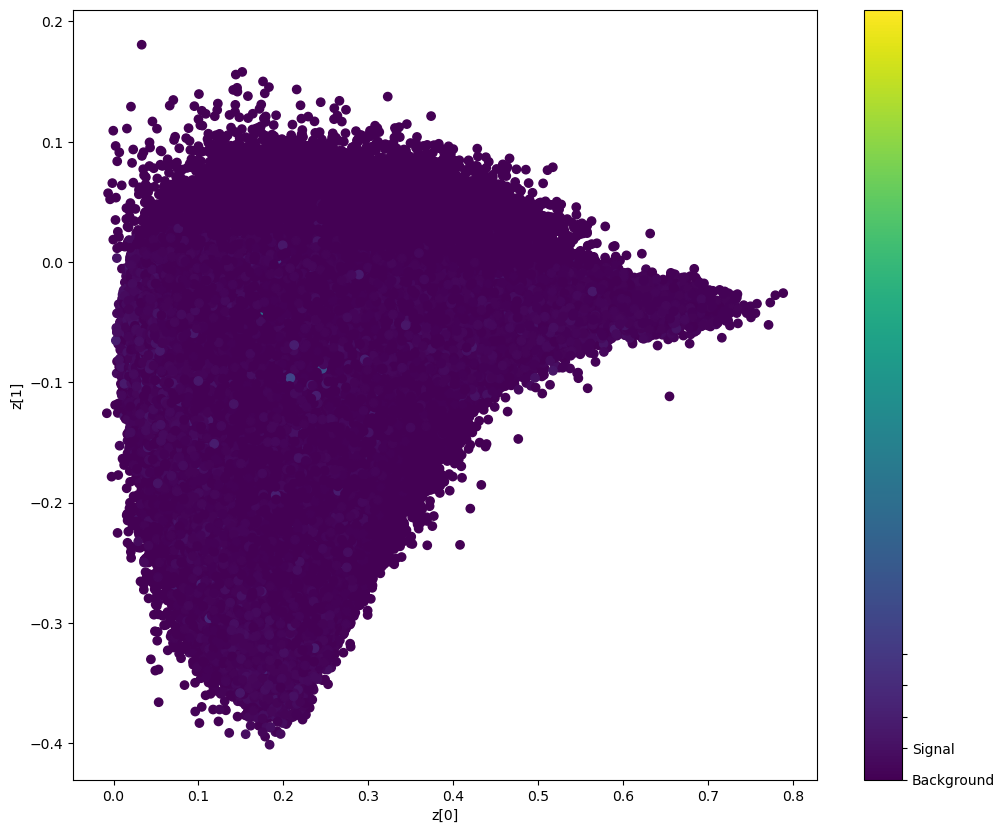

In [62]:
plot_label_clusters(encoder, decoder, x_train, y_train)

# Confusion Matrices

In [27]:
df_test = pd.read_csv('df_bkg_red.csv').drop(columns = 'Unnamed: 0')
df_test = pd.concat([df_test, pd.read_csv('df_model%s_red.csv'%(model)).drop(columns = 'Unnamed: 0')]) 
x_train, x_test, y_train, y_test = train_test_split(df_test.iloc[:, :-2], df_test.iloc[:, -2], test_size=0.2, random_state=42)
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [28]:
x_train

array([[0.30605387, 0.39268005, 0.09330448, ..., 0.5892049 , 0.19314642,
        0.10569106],
       [0.14833713, 0.30091265, 0.01061912, ..., 0.43768003, 0.1152648 ,
        0.09214092],
       [0.13992336, 0.10825533, 0.04266556, ..., 0.65267303, 0.13707165,
        0.12737127],
       ...,
       [0.28034739, 0.5416309 , 0.10625073, ..., 0.78023835, 0.20249221,
        0.10298103],
       [0.13150085, 0.28485555, 0.09057013, ..., 0.8105394 , 0.05607477,
        0.08672087],
       [0.25107116, 0.39226549, 0.14106475, ..., 0.43675462, 0.16199377,
        0.23306233]])

In [41]:
def make_cm(model):
    df_test = pd.read_csv('df_bkg_red.csv').drop(columns = 'Unnamed: 0')
    df_test = pd.concat([df_test, pd.read_csv('df_model%s_red.csv'%(model)).drop(columns = 'Unnamed: 0')], ignore_index=True) 
    x_train, x_test, y_train, y_test = train_test_split(df_test.iloc[:, :-2], df_test.iloc[:, -2], test_size=0.2, random_state=42)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    _, _, z = encoder.predict(x_train)
    y_preds = decoder.predict(z)
    y_test = x_train.flatten()
    y_test = np.around(y_test)
    y_pred = y_preds.flatten()
    y_pred = np.around(y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    print('Model %s\nPrecision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(model, precision, recall, f1, accuracy))
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    tick_labs = ['Background', 'Model %s'%(model)]
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tick_labs)
    fig, ax = plt.subplots(figsize = (10, 7))
    cm_display.plot(ax=ax)
    plt.show()

32306/32306 [==============================] - 19s 590us/step
Model A
Precision: 0.718
Recall: 0.499
F1: 0.564
Accuracy: 0.499


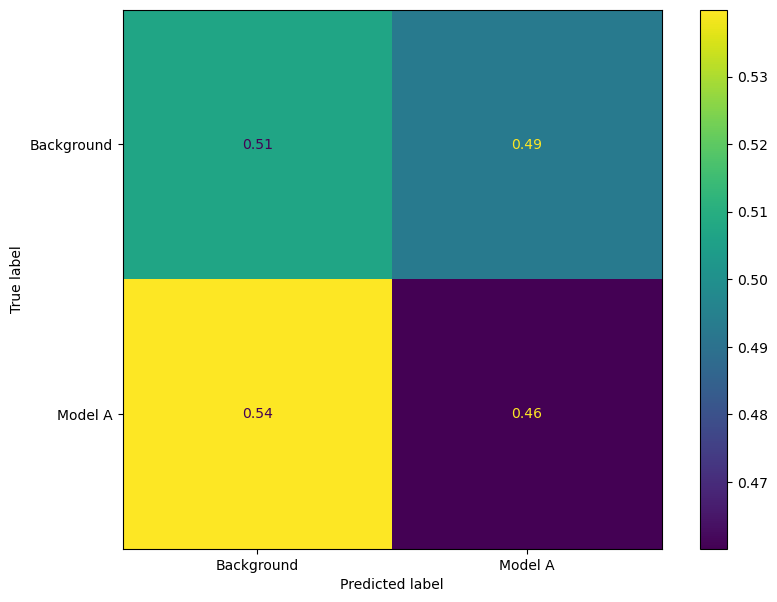

32306/32306 [==============================] - 18s 563us/step
Model B
Precision: 0.717
Recall: 0.496
F1: 0.562
Accuracy: 0.496


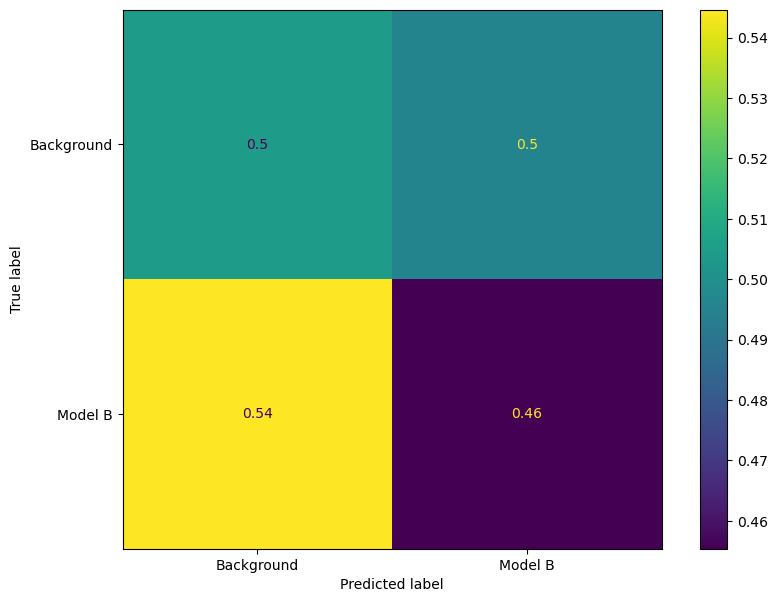

32306/32306 [==============================] - 18s 567us/step
Model C
Precision: 0.719
Recall: 0.498
F1: 0.563
Accuracy: 0.498


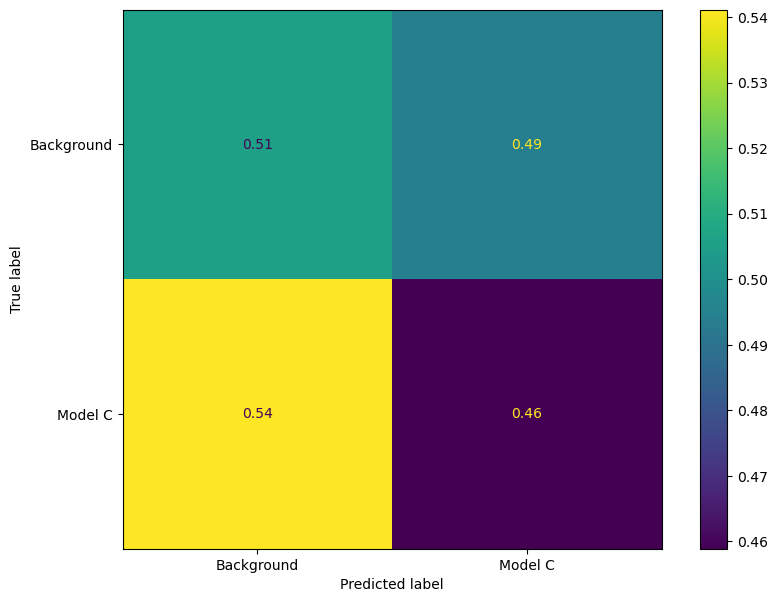

32306/32306 [==============================] - 18s 561us/step
Model D
Precision: 0.718
Recall: 0.498
F1: 0.564
Accuracy: 0.498


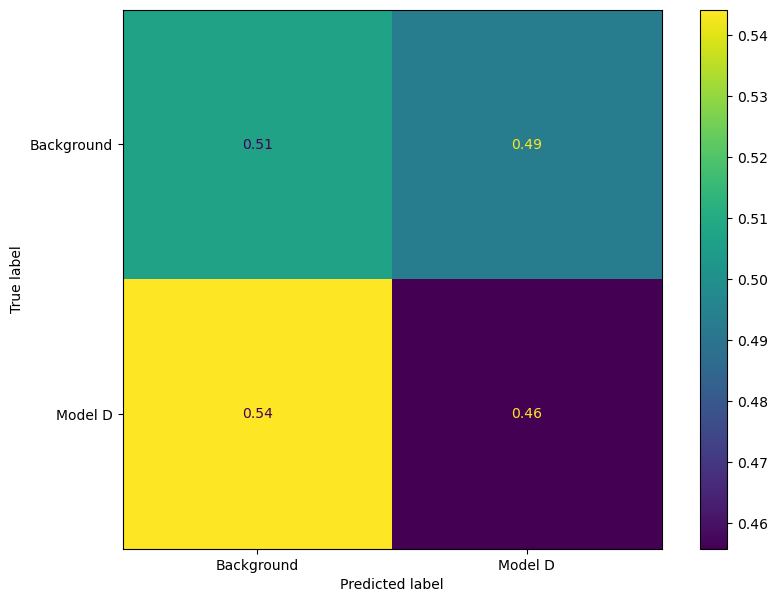

In [42]:
for model in models:
    make_cm(model)

In [43]:
df_bkgsig = df_test.copy() 
df_bkgsig.labels = df_test.labels.replace([2, 3, 4], 1)

In [44]:
x_train, x_test, y_train, y_test = train_test_split(df_bkgsig.iloc[:, :-2], df_bkgsig.iloc[:, -2], test_size=0.2, random_state=42)

In [45]:
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [46]:
labs = {0:'Background', 1:'Signal'}

In [47]:
def plot_label_clusters(encoder, decoder, data, test_lab):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize =(12, 10))
    sc = plt.scatter(z_mean[:, 0], z_mean[:, 1], c = test_lab)
    cbar = plt.colorbar(sc, ticks = range(2))
    cbar.ax.set_yticklabels([labs.get(i) for i in range(2)])
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

66375/66375 [==============================] - 47s 702us/step


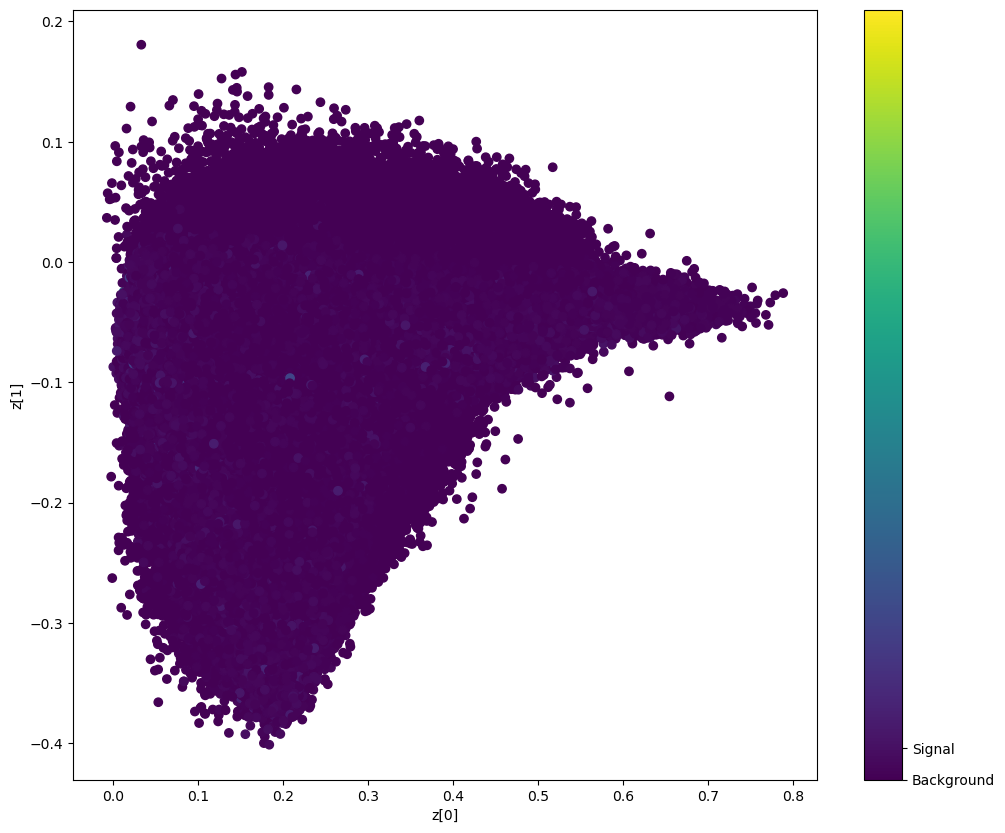

In [48]:
plot_label_clusters(encoder, decoder, x_train, y_train)

In [49]:
_, _, z = encoder.predict(x_train)
y_preds = decoder.predict(z)

66375/66375 [==============================] - 37s 561us/step


In [50]:
y_test = x_train.flatten()
y_test = np.around(y_test)

In [51]:
y_pred = y_preds.flatten()
y_pred = np.around(y_pred)

In [52]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print('Precision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(precision, recall, f1, accuracy))

Precision: 0.148
Recall: 0.456
F1: 0.224
Accuracy: 0.498


In [53]:
_, _, z = encoder.predict(x_test)
y_preds = decoder.predict(z)

16594/16594 [==============================] - 10s 591us/step


In [54]:
y_test = x_test.flatten()
y_test = np.around(y_test)

In [55]:
y_pred = y_preds.flatten()
y_pred = np.around(y_pred)

In [56]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print('Precision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(precision, recall, f1, accuracy))

Precision: 0.149
Recall: 0.456
F1: 0.225
Accuracy: 0.498


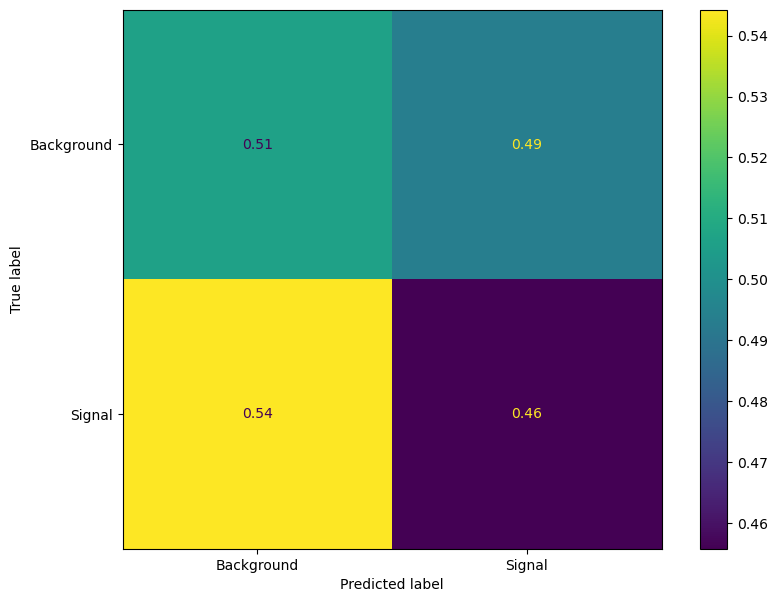

In [57]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
tick_labs = ['Background', 'Signal']
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tick_labs)
fig, ax = plt.subplots(figsize = (10, 7))
cm_display.plot(ax=ax)
plt.show()

In [29]:
df_test = pd.read_csv('red_test_df.csv').drop(columns = 'Unnamed: 0')
x_ass = red_test_df.iloc[:, :-2]
labels = red_test_df.labels
x_ass = np.array(x_ass)

In [30]:
x_ass

array([[1.72825142e-01, 7.75214289e-03, 3.61932188e-03, ...,
        2.48659492e-01, 9.97067449e-02, 2.04022989e-01],
       [1.01328780e-01, 5.18623564e-04, 1.31093117e-01, ...,
        9.29398909e-02, 7.62463343e-02, 9.19540230e-02],
       [3.38633289e-01, 3.73780045e-01, 2.92413945e-02, ...,
        6.33743413e-01, 1.61290323e-01, 1.35057471e-01],
       ...,
       [1.91783772e-01, 6.25634957e-02, 3.54070329e-02, ...,
        4.32012806e-01, 4.69208211e-02, 1.03448276e-01],
       [1.29664198e-01, 1.36795386e-01, 7.20381273e-03, ...,
        4.27853683e-01, 1.11436950e-01, 1.23563218e-01],
       [1.94920401e-01, 3.53721790e-01, 1.02551151e-01, ...,
        7.16002931e-01, 6.74486804e-02, 1.52298851e-01]])

In [43]:
models = ['A', 'B', 'C', 'D']
nums = [1, 2, 3, 4]
def make_cm(model, num):
    df_test = pd.read_csv('red_test_df.csv').drop(columns = 'Unnamed: 0')
    x_ass_full = pd.concat([df_test[df_test.labels == 0], df_test[df_test.labels == num]])
    #print(x_ass)
    x_ass = x_ass_full.iloc[:, :-2]
    x_ass = x_ass.sample(frac=1.0, random_state=42)
    labels = x_ass_full.labels
    labels = labels.sample(frac=1.0, random_state=42)
    x_ass = np.array(x_ass)
    _, _, z = encoder.predict(x_ass)
    y_preds = decoder.predict(z)
    y_test = x_ass.flatten()
    y_test = np.around(y_test)
    y_pred = y_preds.flatten()
    y_pred = np.around(y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    print('Model %s\nPrecision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(model, precision, recall, f1, accuracy))
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    tick_labs = ['Background', 'Model %s'%(model)]
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tick_labs)
    fig, ax = plt.subplots(figsize = (10, 7))
    cm_display.plot(ax=ax)
    plt.show()

6395/6395 [==============================] - 3s 489us/step
Model A
Precision: 0.783
Recall: 0.838
F1: 0.769
Accuracy: 0.838


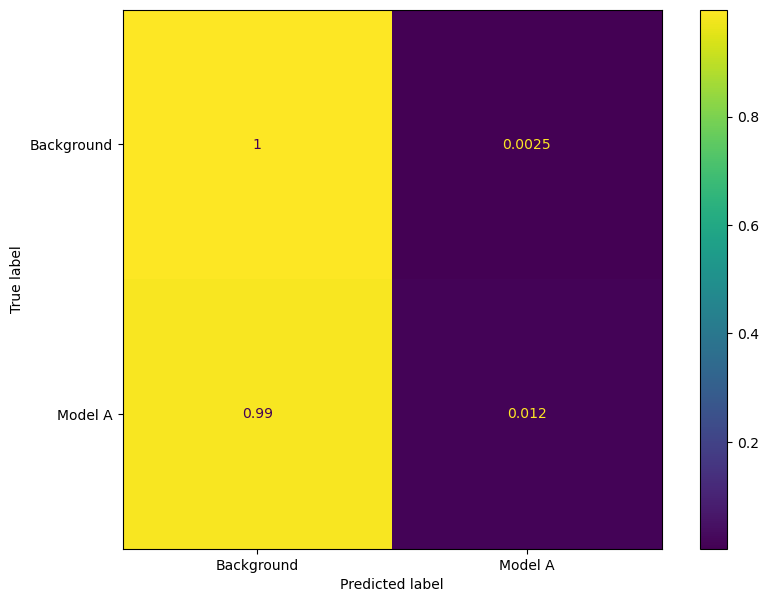

6393/6393 [==============================] - 3s 498us/step
Model B
Precision: 0.784
Recall: 0.839
F1: 0.769
Accuracy: 0.839


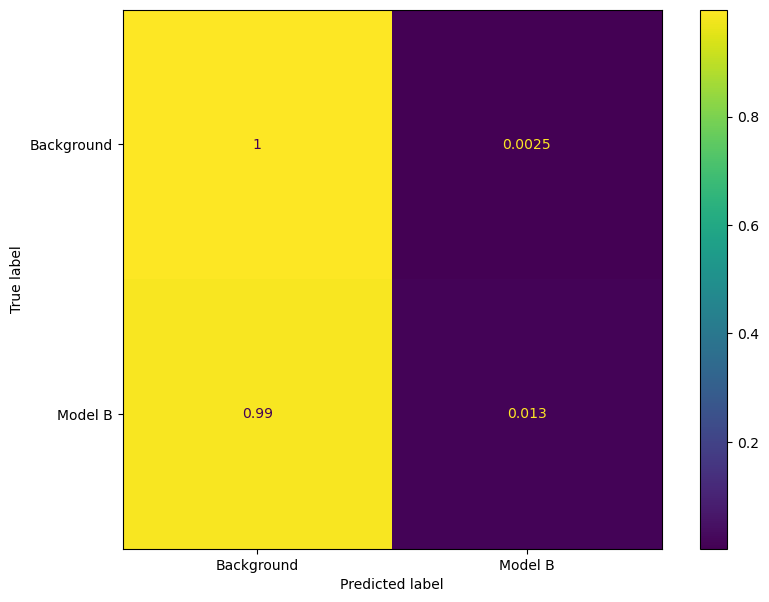

6395/6395 [==============================] - 3s 484us/step
Model C
Precision: 0.784
Recall: 0.839
F1: 0.769
Accuracy: 0.839


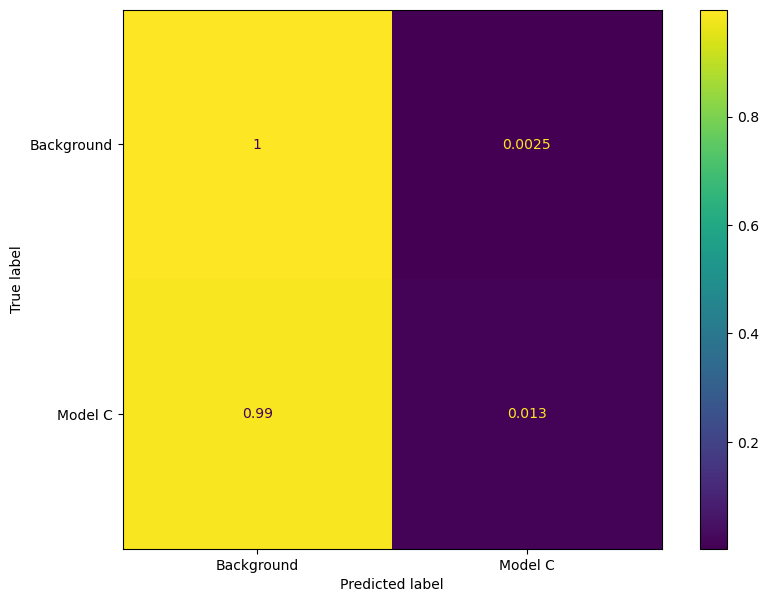

6393/6393 [==============================] - 3s 487us/step
Model D
Precision: 0.785
Recall: 0.839
F1: 0.769
Accuracy: 0.839


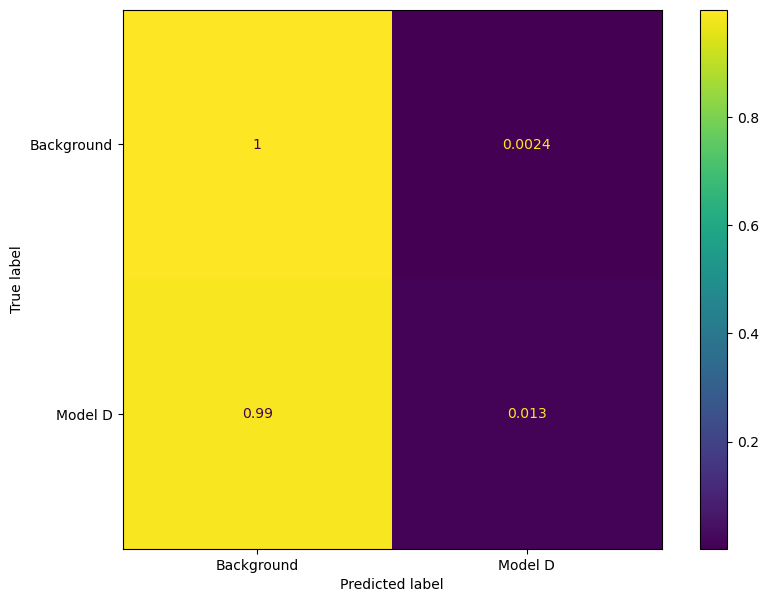

In [44]:
for i in range(len(models)):
    make_cm(models[i], nums[i])

In [45]:
def make_cm():
    df_test = pd.read_csv('red_test_df.csv').drop(columns = 'Unnamed: 0')
    x_ass = df_test.iloc[:, :-2]
    labels = df_test.binary_labels
    x_ass = np.array(x_ass)
    _, _, z = encoder.predict(x_ass)
    y_preds = decoder.predict(z)
    y_test = x_ass.flatten()
    y_test = np.around(y_test)
    y_pred = y_preds.flatten()
    y_pred = np.around(y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    print('Model %s\nPrecision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(model, precision, recall, f1, accuracy))
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    tick_labs = ['Background', 'Signal']
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tick_labs)
    fig, ax = plt.subplots(figsize = (10, 7))
    cm_display.plot(ax=ax)
    plt.show()

6406/6406 [==============================] - 3s 495us/step
Model D
Precision: 0.783
Recall: 0.838
F1: 0.769
Accuracy: 0.838


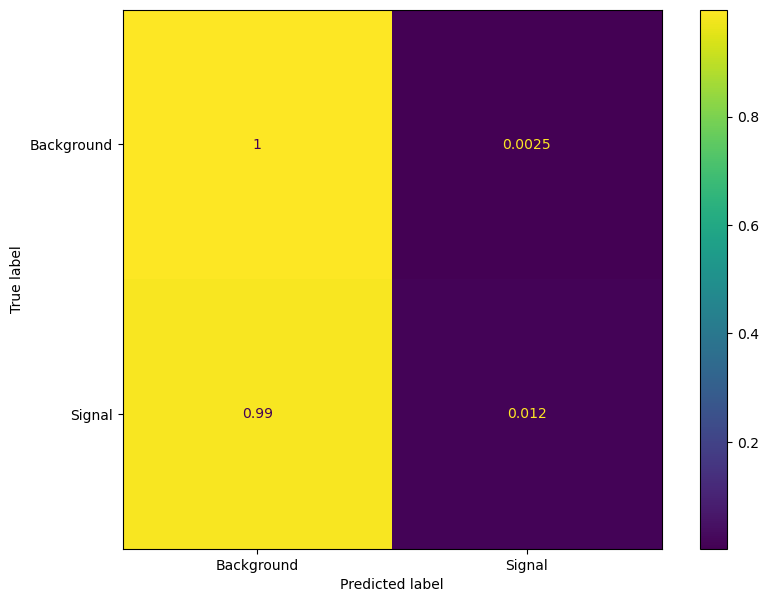

In [46]:
make_cm()

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
import math

In [13]:
nbc = vae

In [14]:
df = pd.read_csv('df_bkg_red.csv').drop(columns = 'Unnamed: 0')
models = ['A', 'B', 'C', 'D']
for i in models:
    df = pd.concat([df, pd.read_csv('df_model%s_red.csv'%(i)).drop(columns = 'Unnamed: 0')]) 

In [15]:
df_bin = df.copy()
df_bin.labels = df.labels.replace([2, 3, 4], 1)

In [16]:
features_bin = df_bin.iloc[:, :-2]
labels_bin = df_bin.labels

In [17]:
features = df.iloc[:, :-2]
labels = df.labels

In [28]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
x_train_bin, x_test_bin, y_train_bin, y_test_bin = train_test_split(features_bin, labels_bin, test_size=0.2, random_state=42)

In [19]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_train_bin = scaler.fit_transform(x_train_bin)
x_test_bin = scaler.fit_transform(x_test_bin)

# ROC Curves

In [29]:
features = np.array(features)

In [30]:
features = MinMaxScaler().fit_transform(features)

In [20]:
_, _, z = encoder.predict(x_test)
y_preds = decoder.predict(z)

12923/12923 [==============================] - 7s 562us/step


In [21]:
y_tst = np.around(x_test.flatten())
y_pred = np.around(y_preds.flatten())

In [22]:
y_tst

array([0., 1., 0., ..., 0., 0., 0.])

In [23]:
y_pred

array([0., 0., 0., ..., 1., 0., 0.], dtype=float32)

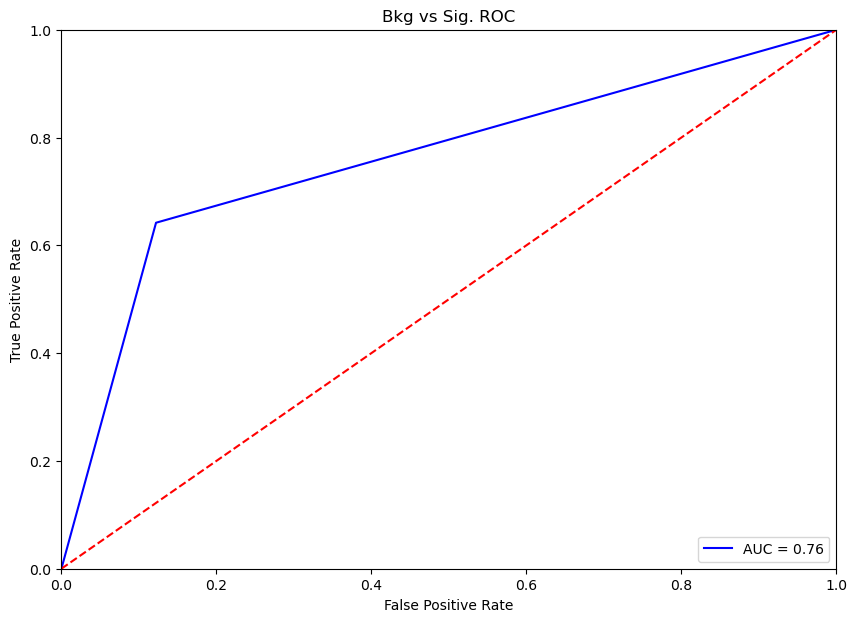

In [24]:
fpr, tpr, threshold = roc_curve(y_tst, y_pred)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.figure(figsize=(10,7))
plt.title('Bkg vs Sig. ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [25]:
opt_thresh_bin = threshold[np.argmax(tpr-fpr)]
opt_thresh_bin

1.0

In [29]:
df_1vr = df.copy()
classes = [1, 2, 3, 4]
fpr_tpr_auc = {}
for i in classes:
    new = classes.copy()
    new.remove(i)
    print(new)
    y_test_new = y_test.replace(to_replace=new, value=0)
    y_test_new = y_test_new.replace(i, 1)
    #features = MinMaxScaler().fit_transform(features)
    #probs = nbc_bin.predict_proba(features)
    #preds = probs[:, 1]
    _, _, z = encoder.predict(x_test)
    preds = decoder.predict(z)
    fpr, tpr, thresh = roc_curve(np.around(x_test.flatten()), np.around(preds.flatten()))
    roc_auc = auc(fpr, tpr)
    fpr_tpr_auc[i] = {}
    fpr_tpr_auc[i]['fpr'] = fpr
    fpr_tpr_auc[i]['tpr'] = tpr
    fpr_tpr_auc[i]['roc_auc'] = roc_auc
    fpr_tpr_auc[i]['threshold'] = thresh

[2, 3, 4]
12923/12923 [==============================] - 8s 584us/step


AttributeError: 'DataFrame' object has no attribute 'flatten'

In [ ]:
models = ['Bkg', 'A', 'B', 'C', 'D']
colours = ['None', 'b', 'r', 'g', 'orange']
plt.figure(figsize=(10,7))
plt.title('One vs Rest ROC Curves')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
for i in fpr_tpr_auc.keys():
    plt.plot(fpr_tpr_auc[i]['fpr'], fpr_tpr_auc[i]['tpr'], 
             colours[i], label = 'Model %s AUC = %0.2f' %(models[i], fpr_tpr_auc[i]['roc_auc']))
    opt_thresh = fpr_tpr_auc[i]['threshold'][np.argmax(fpr_tpr_auc[i]['tpr']-fpr_tpr_auc[i]['fpr'])]
    print('Model %s optimum classification threshold: %0.3f'%(models[i], opt_thresh))
plt.legend(loc = 'lower right')
plt.show()